# Class 3: Data Manipulation with NumPy & Pandas (EE Sensor Workflow)

### Overview

Lists are fine for toy problems, but real sensor logs want **NumPy** arrays and **Pandas** DataFrames. Today you’ll do vectorized math (blazingly fast), clean noisy measurements, compute rolling stats, and get your data “ML-ready.”

---

### Lecture Notes (short + teachable)

* **NumPy arrays**: contiguous, typed, vectorized. Use for numerical ops, filters, FFTs later.
* **Vectorization**: operate on entire arrays without explicit Python loops.
* **Pandas Series/DataFrame**: labeled columns/rows, CSV I/O, missing-value handling, groupby, rolling windows.
* **Mini-pipeline**: load CSV → convert to arrays → clean (drop/clip/fill) → features (mean/std/rolling) → save.

EE hook: Think of **NumPy** as your DSP breadboard and **Pandas** as the lab notebook that keeps measurements tidy.

---

0) Setup & Tiny CSV (so notebook is self-contained)



In [9]:
# If running in a fresh Colab, install nothing (NumPy/Pandas come preinstalled).
import numpy as np
import pandas as pd

In [10]:
# Create a small demo CSV to simulate sensor data (time_s, voltage_v)
pd.DataFrame({
    "time_s": np.arange(0, 10, 1),
    "voltage_v": [3.10, 3.22, 3.15, 3.50, 5.00, 3.25, 3.18, np.nan, 3.21, 3.20]  # includes a spike and a NaN
}).to_csv("sensor_demo.csv", index=False)

# !head -n 5 sensor_demo.csv

### 1) NumPy essentials: arrays, indexing, vectorized math



In [11]:
import numpy as np

# Create arrays
t = np.arange(0, 10, 1, dtype=float)        # times 0..9
v = np.array([3.10, 3.22, 3.15, 3.50, 5.00, 3.25, 3.18, 3.30, 3.21, 3.20])

print("t shape:", t.shape, "v shape:", v.shape)

# Vectorized operations (no explicit loops)
dv = np.diff(v)               # first difference (approx derivative)
scaled = v * 1000             # convert V to mV
mask_spike = v > 4.5          # detect spikes
print("Δv:", dv)
print("Any spikes?", mask_spike.any(), "| spike indices:", np.where(mask_spike)[0])

# Boolean filtering
v_wo_spike = v[~mask_spike]
print("Mean voltage without spike:", v_wo_spike.mean())

t shape: (10,) v shape: (10,)
Δv: [ 0.12 -0.07  0.35  1.5  -1.75 -0.07  0.12 -0.09 -0.01]
Any spikes? True | spike indices: [4]
Mean voltage without spike: 3.2344444444444442


### 2) Pandas essentials: DataFrame loading, cleaning, selection



In [12]:
import pandas as pd

df = pd.read_csv("sensor_demo.csv")
print(df.head())

# Identify missing values (NaN)
print("Missing values:\n", df.isna().sum())

# Simple cleaning strategies
df["voltage_v_filled"] = df["voltage_v"].interpolate(limit_direction="both")  # fill NaN via linear interpolation
# Clip extreme spikes to a safe range (e.g., 3.0 to 3.6 V)
df["voltage_v_clipped"] = df["voltage_v_filled"].clip(lower=3.0, upper=3.6)

print(df)

   time_s  voltage_v
0       0       3.10
1       1       3.22
2       2       3.15
3       3       3.50
4       4       5.00
Missing values:
 time_s       0
voltage_v    1
dtype: int64
   time_s  voltage_v  voltage_v_filled  voltage_v_clipped
0       0       3.10             3.100              3.100
1       1       3.22             3.220              3.220
2       2       3.15             3.150              3.150
3       3       3.50             3.500              3.500
4       4       5.00             5.000              3.600
5       5       3.25             3.250              3.250
6       6       3.18             3.180              3.180
7       7        NaN             3.195              3.195
8       8       3.21             3.210              3.210
9       9       3.20             3.200              3.200


### 3) Rolling stats and basic features

In [13]:
# Rolling mean/STD provide smoothed signals & variability measures
df["roll_mean_3"] = df["voltage_v_clipped"].rolling(window=3, min_periods=1).mean()
df["roll_std_3"]  = df["voltage_v_clipped"].rolling(window=3, min_periods=1).std()

# Simple gradient (first difference) using NumPy on the cleaned column
grad = np.gradient(df["voltage_v_clipped"].to_numpy())
df["grad"] = grad

display(df)

,time_s,voltage_v,voltage_v_filled,voltage_v_clipped,roll_mean_3,roll_std_3,grad
0,0,3.10,3.100,3.100,3.100000,NaN,0.1200
1,1,3.22,3.220,3.220,3.160000,0.084853,0.0250
2,2,3.15,3.150,3.150,3.156667,0.060277,0.1400
3,3,3.50,3.500,3.500,3.290000,0.185203,0.2250
4,4,5.00,5.000,3.600,3.416667,0.236291,-0.1250
5,5,3.25,3.250,3.250,3.450000,0.180278,-0.2100
6,6,3.18,3.180,3.180,3.343333,0.225019,-0.0275
7,7,NaN,3.195,3.195,3.208333,0.036856,0.0150
8,8,3.21,3.210,3.210,3.195000,0.015000,0.0025
9,9,3.20,3.200,3.200,3.201667,0.007638,-0.0100


### 4) Quick sanity visualization (tiny preview)

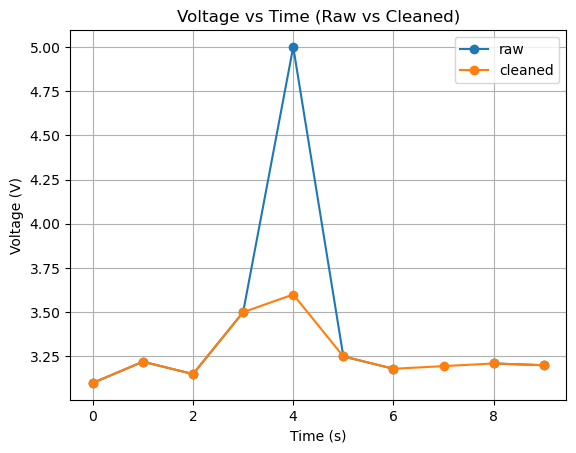

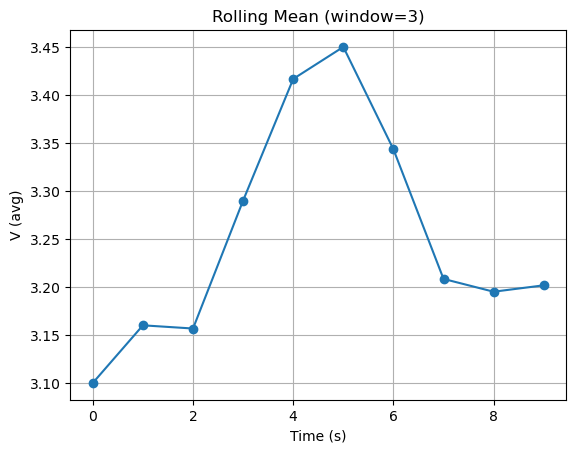

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["time_s"], df["voltage_v"], marker="o", label="raw")
plt.plot(df["time_s"], df["voltage_v_clipped"], marker="o", label="cleaned")
plt.title("Voltage vs Time (Raw vs Cleaned)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(df["time_s"], df["roll_mean_3"], marker="o")
plt.title("Rolling Mean (window=3)")
plt.xlabel("Time (s)")
plt.ylabel("V (avg)")
plt.grid(True)
plt.show()

### 5) Save processed data (for next classes / ML prep)



In [15]:
cols_to_save = ["time_s", "voltage_v", "voltage_v_filled", "voltage_v_clipped", "roll_mean_3", "roll_std_3", "grad"]
df[cols_to_save].to_csv("sensor_processed.csv", index=False)
!head -n 5 sensor_processed.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


## Classworks (5) — Skeleton Code (students fill the blanks)
### Classwork 1: NumPy vector ops + masking



In [16]:

# ==============================================
# CLASSWORK 1: NUMPY VECTORS + MASKING
# ==============================================
# Task:
# 1) Create a NumPy array 'v' of 8 voltage readings.
# 2) Create a boolean mask to find values > 3.4 V.
# 3) Compute mean of the non-spike values only.
# 4) Compute the first difference (np.diff) and print.


import numpy as np

# v = np.array([???, ???, ???, ???, ???, ???, ???, ???], dtype=float)
# mask = v > ???           # threshold
# v_clean = v[???]         # select non-spike values
# print("Mean (no spikes):", ???.mean())
# print("First difference:", np.diff(???))

### Classwork 2: Pandas load + clean

In [17]:
# ==============================================
# CLASSWORK 2: PANDAS LOAD + CLEAN
# ==============================================
# Task:
# 1) Read 'class3_small.csv' with columns time_s, voltage_v (create it if missing).
# 2) Interpolate missing voltages.
# 3) Clip to a safe range [3.0, 3.6].
# 4) Print head() and count NaNs after cleaning.

import pandas as pd

# df = pd.read_csv("class3_small.csv")  # create if not present
# df["voltage_v_filled"] = df["voltage_v"].???(limit_direction="both")
# df["voltage_v_clipped"] = df["voltage_v_filled"].???(lower=???, upper=???)
# print(df.???())         # show first rows
# print("NaNs after cleaning:\n", df.???.sum())

### Classwork 3: Rolling features


In [18]:
# ==============================================
# CLASSWORK 3: ROLLING FEATURES
# ==============================================
# Task:
# Using a cleaned column (e.g., 'voltage_v_clipped'):
# 1) Compute rolling mean with window=5 (min_periods=1).
# 2) Compute rolling std with window=5.
# 3) Add both as new columns and print last 5 rows.

# df["roll_mean_5"] = df["voltage_v_clipped"].rolling(window=???, min_periods=1).???
# df["roll_std_5"]  = df["voltage_v_clipped"].rolling(window=???, min_periods=1).???
# print(df.tail(???))

### Classwork 4: From Pandas to NumPy and back



In [19]:
# ==============================================
# CLASSWORK 4: PANDAS <-> NUMPY
# ==============================================
# Task:
# 1) Take the cleaned voltage column as a NumPy array (to_numpy()).
# 2) Compute gradient using np.gradient.
# 3) Assign back to df["grad_np"] and save to 'class3_out.csv'.

import numpy as np

# v_clean = df["voltage_v_clipped"].???()
# g = np.???(v_clean)
# df["grad_np"] = g
# df.to_csv("class3_out.csv", index=???)
# print("Saved to class3_out.csv; shape:", df.shape)



### Classwork 5: Mini EE feature engineering


In [20]:

# ==============================================
# CLASSWORK 5: MINI EE FEATURE ENGINEERING
# ==============================================
# Task:
# Assume 'time_s' is uniformly sampled 1 Hz.
# Build features for ML:
#   - mean over last 4 samples
#   - std over last 4 samples
#   - simple slope over last 4 samples (use np.polyfit or finite diff)
# Save only ['time_s','voltage_v_clipped','f_mean4','f_std4','f_slope4'] to CSV.

import numpy as np

# df["f_mean4"] = df["voltage_v_clipped"].rolling(window=???, min_periods=1).???
# df["f_std4"]  = df["voltage_v_clipped"].rolling(window=???, min_periods=1).???
# # Slope: option A (polyfit on a sliding window), option B (finite difference on last 4)
# # Hint for A:
# # def slope_last4(arr):
# #     x = np.arange(len(arr))[-4:]  # last 4 indices
# #     y = arr[-4:]
# #     return np.polyfit(x, y, 1)[0]
# #
# # You can compute with rolling.apply using raw=True and a helper function.
#
# # df["f_slope4"] = df["voltage_v_clipped"].rolling(window=4, min_periods=1).apply(???, raw=True)
#
# out_cols = ["time_s","voltage_v_clipped","f_mean4","f_std4","f_slope4"]
# df[out_cols].to_csv("features_class3.csv", index=False)
# print("Feature file saved: features_class3.csv")

### Wrap-up / Homework Challenge

* Extend Classwork 5 with **outlier detection**: flag any window where `f_std4` exceeds a threshold (e.g., 0.15 V). Create a boolean column `is_anomaly`.
* Bonus: Plot cleaned signal with anomaly points highlighted (scatter) and write a 2-line comment: what does the anomaly likely represent (sensor glitch? transient load change?).
